# Importing Libraries

In [24]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder


# Loading Dataset

In [25]:
df=pd.read_csv('/content/drive/MyDrive/Datathon.csv')

In [26]:
df['Emotion']

0          UPSET
1       OPTIMISM
2        NEUTRAL
3        NEUTRAL
4          UPSET
          ...   
1612    OPTIMISM
1613    OPTIMISM
1614     NEUTRAL
1615         JOY
1616    OPTIMISM
Name: Emotion, Length: 1617, dtype: object

# Data Cleaning and Preprocessing

In [27]:
df=df.dropna()

In [28]:
df=df[['Text_of_Speech','Emotion']]

In [29]:
df.isnull().sum()

Text_of_Speech    0
Emotion           0
dtype: int64

In [30]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [31]:
df['Text_of_Speech'] = df['Text_of_Speech'].apply(clean_text)
df.head()

,Text_of_Speech,Emotion
0,esteemed mr lebedevladies and gentlemenyou hav...,UPSET
1,the president good evening my fellow american...,OPTIMISM
2,good afternoon dear colleaguesour meeting toda...,NEUTRAL
3,good afternoon everybody this sound system is ...,NEUTRAL
4,more americans voted in the elections than an...,UPSET


In [32]:
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
stop_words = stopwords.words('english')

In [39]:
#stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['Text_of_Speech'] = df['Text_of_Speech'].apply(remove_stopwords)
df.head()

,Text_of_Speech,Emotion
0,esteemed mr lebedevladies gentlemenyou gathere...,UPSET
1,president good evening fellow americans want...,OPTIMISM
2,good afternoon dear colleaguesour meeting toda...,NEUTRAL
3,good afternoon everybody sound system really p...,NEUTRAL
4,americans voted elections election nation’s h...,UPSET


In [40]:
import nltk
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [41]:
df['Text_of_Speech'] = df['Text_of_Speech'].apply(stemm_text)

In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Emotion'])

In [43]:
df['Target'][0]

3

# Splitting the Dataset Into Training and testing

In [44]:
x_train, x_test, y_train, y_test = train_test_split(df['Text_of_Speech'], df['Target'], test_size=0.3, random_state=42)


In [45]:
x_train.shape

(1123,)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
X_test_tfidf = tfidf_vectorizer.transform(x_test)

In [50]:
X_train_tfidf

<1123x28606 sparse matrix of type '<class 'numpy.float64'>'
	with 387410 stored elements in Compressed Sparse Row format>

# Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
lr=LogisticRegression()

In [53]:
lr.fit(X_train_tfidf,y_train)

LogisticRegression()

In [54]:
y_pred = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=['UPSET','JOY','OPTIMISM','NEUTRAL']))


              precision    recall  f1-score   support

       UPSET       0.50      0.62      0.55       117
         JOY       0.44      0.48      0.46       147
    OPTIMISM       0.43      0.47      0.45       137
     NEUTRAL       0.71      0.27      0.39        81

    accuracy                           0.47       482
   macro avg       0.52      0.46      0.46       482
weighted avg       0.50      0.47      0.47       482



In [55]:
from sklearn.metrics import accuracy_score

# Assuming you have already made predictions y_pred
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.4730290456431535


In [56]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text_of_Speech'])
X = tokenizer.texts_to_sequences(df['Text_of_Speech'])
max_seq_length = 250
X = pad_sequences(X, maxlen=max_seq_length, padding='post', truncating='post')
X_train, X_test, y_train, y_test = train_test_split(X, df['Target'], test_size=0.2, random_state=42)


In [57]:
X.shape

(1605, 250)

# LSTM

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # You can adjust this dimension
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
num_classes = 4
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          3794400   
                                                                 
 lstm (LSTM)                 (None, 250, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 250, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 4043748 (15.43 MB)
Trainable params: 40437

In [59]:
X_train.shape

(1284, 250)

In [60]:
batch_size = 64
epochs = 25

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)


Epoch 1/25
21/21 [==============================] - 30s 1s/step - loss: 1.3618 - accuracy: 0.3022
Epoch 2/25
21/21 [==============================] - 24s 1s/step - loss: 1.3330 - accuracy: 0.3123
Epoch 3/25
21/21 [==============================] - 23s 1s/step - loss: 1.1973 - accuracy: 0.4868
Epoch 4/25
21/21 [==============================] - 24s 1s/step - loss: 0.8598 - accuracy: 0.6503
Epoch 5/25
21/21 [==============================] - 26s 1s/step - loss: 0.4969 - accuracy: 0.7897
Epoch 6/25
21/21 [==============================] - 22s 1s/step - loss: 0.3384 - accuracy: 0.8505
Epoch 7/25
21/21 [==============================] - 26s 1s/step - loss: 0.3076 - accuracy: 0.8575
Epoch 8/25
21/21 [==============================] - 22s 1s/step - loss: 0.2768 - accuracy: 0.8715
Epoch 9/25
21/21 [==============================] - 24s 1s/step - loss: 0.2874 - accuracy: 0.8598
Epoch 10/25
21/21 [==============================] - 24s 1s/step - loss: 0.2599 - accuracy: 0.8801
Epoch 11/25
21/21 [

# GRU

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

model = Sequential()
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
num_classes = 4
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 300)          11383200  
                                                                 
 gru (GRU)                   (None, 250, 128)          165120    
                                                                 
 dropout_2 (Dropout)         (None, 250, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 11647908 (44.43 MB)
Trainable params: 11

In [64]:
model.save('Model_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Training

In [66]:
batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)


Epoch 1/5
21/21 [==============================] - 33s 2s/step - loss: 0.2992 - accuracy: 0.2874
Epoch 2/5
21/21 [==============================] - 28s 1s/step - loss: 0.3635 - accuracy: 0.3030
Epoch 3/5
21/21 [==============================] - 28s 1s/step - loss: 0.2929 - accuracy: 0.3053
Epoch 4/5
21/21 [==============================] - 31s 1s/step - loss: 0.2955 - accuracy: 0.2835
Epoch 5/5
21/21 [==============================] - 28s 1s/step - loss: 0.2925 - accuracy: 0.3045


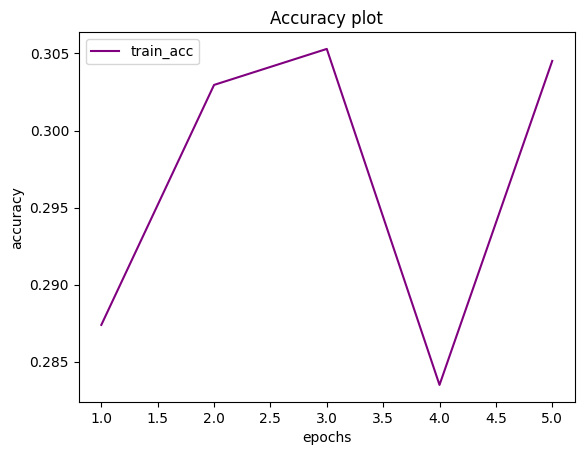

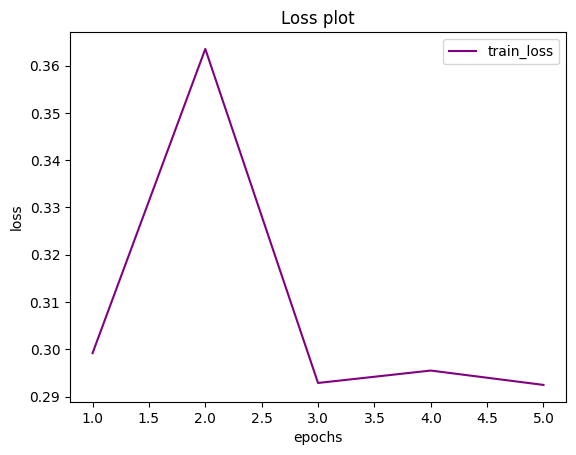

In [67]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss"])
plt.show()

In [ ]:

input_text = "esteem mr lebedevladi gentlemenyou gather sum result past year sure end discuss year russia turn new page histori right time open discuss chang taken place judici system last decad look like near futureof legal profession judg alway enjoy special prestig prais measur approach word action hand law acquir real power becom instrument uphold justic act behalf state hand verdict behalf russian federationa court law mean power enorm power entail huge respons usual view court disciplinari machin give speedi alway fair judgment confin past habit seek protect superior replac peopl mind understand conveni advantag take matter court defend right assistancetoday citizen will frequent judici system court live higher expect go talk good opportun ponder current condit judici systemat present  crimin civil case await trial russian court almost  case tri moscow court alon januari  past year  case return investig onethird verdict delayedregrett figur show busi judg also mani peopl still wait fair resolut problem meanwhil mani case problem determin futur fulli awar defend spend month sometim year detent facil hear civil case involv hous inherit famili issu delay agesmeanwhil peopl judg effect govern power integr court level democraci world matter reason huge liabil judiciari countri leader therefor govern author wholeth judiciari real independ best indic state base rule law old univers problem old world time anatoli koni said judg “protect condit conduc cowardic forc assentation” hit nail headregrett wit relaps old attitud court appendag bureaucrat machinefor instanc russian presid prerog deleg power judg context alarm region leader tri place judici system controleveryon rememb ingush leader attempt hold republican referendum procedur appoint judg violat feder law guarante equal right citizen throughout russiamoreov constitut russian republ still contain claus resid appoint judg formula dozen transgressionsi would like say right away fulli support posit suprem court russian feder council judg oppos encroach exist procedur form court appoint feder judgesi equal talk revis judiciari current status impos limit guarante immun independ autonomi sanction law attempt transgress upon constitut principl nip budmor eight year ago suprem soviet russian feder approv judiciari reform concept aim creat strong independ legal systemth judiciari took direct part process renew suprem court initi adopt law militari tribun judici depart fund court russian feder import adopt legisl judici system still ridden mani serious problem mani task still ahead itfirst legal foundat administ justic full accord russian constitut unjustifi delay adopt basic law court law new code crimin legal proceed legisl act administr proceed court bad need work russia constitut court alreadi issu  resolut discrep individu provis code crimin proceed constitut general messag resolut reinforc adversari proceed mayb time implement full constitut rule wherebi person may arrest detain basi court rule mean right give serious thoughtsecond old rule provid effect legal protect law right interest citizen particular rule relat provid broader access justic defenc preliminari investigationfin russian legisl reform line univers recogn norm intern lawyou know may   russia ratifi convent protect human right fundament freedom becom part legal system addit recogn jurisdict european court human right today must pay special attent problem russian judici system european court may object tofirst appli meet reason deadlin court deliber european court accept excus overload lack judg shortag fund nation court drag trialstoday would like discuss anoth key aspect activ – case involv econom crime transit central plan economi one govern market imposs without strengthen foundat latter primarili effect perform legal institutionsin regul economi state primarili guarante market streamlin function stabl environ demand fulli appli legisl execut branch govern also court law arbitrationth new civil crimin code combin two approach protect right law interest particip econom relat one hand guarante entrepreneur freedom econom perform right hand interest state demand econom agent well role guarante interest particip promot tax collect well combat money launder illeg export capitali would like stress one point govern heavili critic abandon economi without reason alreadi mention sever time believ repeat talk colleagu state interfer economi case resurrect commandbas plan economi instead creat power lever understand rule enforc addit regul economi state make sure rule everyon guarante market player follow case transpar attract invest environ needless say state creat new mechan also keep old one good shapethi direct appli fund judici system recent question becam urgent russia constitut court sayarticl  constitut read “court law shall financ feder budget financ shall ensur full independ administr justic accord feder law”thi concern fund programm develop judici system also financi support judg receiv modest salari deal case worth billion roubl fight crime danger offend without proper protect yourselvesthes realiti today give much reason optim goe without say everyth compli state abil also clear state want everyth function normal product economi effect institut must pay attent thisi want make promis would wrong speak big rise salari would like know understand rise necessari certain move direct must say much alreadi done give judg due last year judg court administr offici receiv full salari time fund increas almost  million roubl order rais offici rate pay half battleprogramm strengthen rule law combat crime adequ fund mani law alreadi pass enforc lack money defend constitut right trial juri put practic reason today trial juri limit nine region russia oper everywherefin sometim lack money court cannot even meet basic need summon wit interpret expert law demand enough form envelop money mail expens still enough comput technic facil court recordsw shirk respons situat work improv alreadi said much effect think state fail pay proper attent problem abl collect tax owe economi perform well therefor tightfist courtsmeanwhil court also take step control expens streamlin cash flow otherwis difficult resist attempt local leader “privatize” court partial fundingther one major problem want point personn alreadi said complaint overload court surfac often becom commonplac inde still  vacanc judgesthi year authoris staff size increas thousand posit presidenti decre feder judg reliev part burden implement feder law justic peac almost  peopl sworn justicesthes plan make even urgent creat effect system train proper screen judg essenti improv screen process also streamlin rule appoint judg remov offic current procedur complic take extrem long time guarante promotionbut would also like say personnel problem limit describ author judici power effect perform larg determin judg qualif unbias attitud needless say averag two three time fewer judg per capita mani western countri deni citizen right speedi trialmi friendsyou know well result work direct effect polit econom life societi court remain key factor safeguard democraci allow russia forg ahead new centuryyou receiv lot extra work sinc decemb elect citizen associ alert violat elector law feder region bodi govern flood complaint like subsid begin summeryou know posit – mean govern posit state societi need honest elect result open honest elect campaign way achiev fullyfledg effect govern way guarante democraci orderdur confer certain talk much implement judici reform let tell straight – reform drag difficult societi look ambigu human faith inviol law depend final result person decenc professionalismi much hope continu guid work principl profession honour judici duti respons homeland would like wish russia judiciari bestthank attent"

# Preprocess the input text
cleaned_text = clean_text(input_text)
text_without_stopwords = remove_stopwords(cleaned_text)
stemmed_text = stemm_text(text_without_stopwords)

# Tokenize and encode the text
input_sequence = tokenizer.texts_to_sequences([stemmed_text])

# Pad sequences
input_sequence = pad_sequences(input_sequence, maxlen=max_seq_length)

# Make predictions
predicted_probabilities = model.predict(input_sequence)

# Convert predictions to class label
predicted_class = predicted_probabilities.argmax(axis=1)[0]

print(f"Predicted Class: {predicted_class}")


In [ ]:
model.save("model.h5")